# Exploration

This notebook builds upon the data processing work and looks to identify informative relationships in the data, specifically between the features created and the outcome variable, the banker's offer at the end of the round. My exploration consists of finding some 'fun facts' about the data as well as building intuition into the different relationships between the variables. Specifically, I explore the following:
- Contestant winnings and deal quality (relative to the game played),
- Offers and their relationship to values remaining on the board, and
- Relevant covariates to build a model to better understand the banker's offer.

I also explore these relationships conditionally across variables such as the round of the game and the season in which the game is played, as I saw a noticeable difference in the early round offers of season 3 compared to the first two seasons of data. Reiterating my hypothesis about the relationship between the values remaining on the board the banker offer, I find a strong linear relationship between the average of the remaining values and the banker's offer across each round. This provides a promising lead for model building and also permits the opportunity to potentially apply a less complicated (and more interpretable) supervised learning algorithm such as linear regression.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
round_data = pd.read_csv('../data/dond_processed_data.csv')
case_values = pd.read_csv('../data/case_values.csv')

## summary

### context

### questions to answer
- deal quality
- offers
- winnings
- offer to remaining value relationship
- intuition for building a model and selecting the model

## Contestant winnings and deal quality

While the following exploration is may be more interesting than useful for modeling the banker's offer, it provides some important context about the data generating process and provides a mental warm-up for how to approach exploring this data. The subsections go into more detail about the results of the exploration and propose possible explanations for the behavior seen, as well as motivate a further look at the banker's offer.

### Winnings

From the five-number summary we see that average winnings ($97k) are larger than median winnings ($76k), and the right-tailed distribution of the histogram indicate that the data are right-skewed. The distribution of winnings does not appear to vary much across seasons on the aggregate. The story gets more interesting looking round by round and across seasons; interestingly, the median winnings appear to remaining relatively constant between rounds 3 through 8 as well as increasing variation in the winnings with each successive round. However, there is a noticeable drop in both median winnings and winnings distribution in rounds 9 and 10 compared to round 8. Looking across seasons, the IQR overlaps for rounds 3 through 8, and there does seem to be a noteworthy difference between seasons 1 and 2 for round 9; this should be viewed cautiously though, as the repeated disaggregation likely did not leave many samples left to make a reasonable comparison.

In summary, the average and median winnings are less than the average case values ($131k), and are right-skewed, as is often the case with the distribution of money. Players who chose to make a deal between rounds 3 through 8 were more likely to walk away with higher winnings than those who waited until the end of the game. This could be a result of the player's risk tolerance and 'getting greedy', as each round increases the likelihood of selecting the largest remaining case on the board. One possible explanation is that players who stay until the later rounds frequently have one large value (i.e. >= $100k) remaining, and are perhaps anchoring their expectations of an offer based on that amount. The data clearly show that this is not a great strategy for maximizing winnings. However, another explanation is that players who finally eliminate their last large value tend to take on much more risk since the relative difference in winnings is much smaller (i.e. only values <$1k remain on the board) and therefore the player is 'numb' from the lost winnings opportunity.

In [3]:
round_data['winnings'].describe()

count       160.000000
mean      97047.662500
std       96059.161125
min           1.000000
25%       22500.000000
50%       75500.000000
75%      129500.000000
max      464000.000000
Name: winnings, dtype: float64

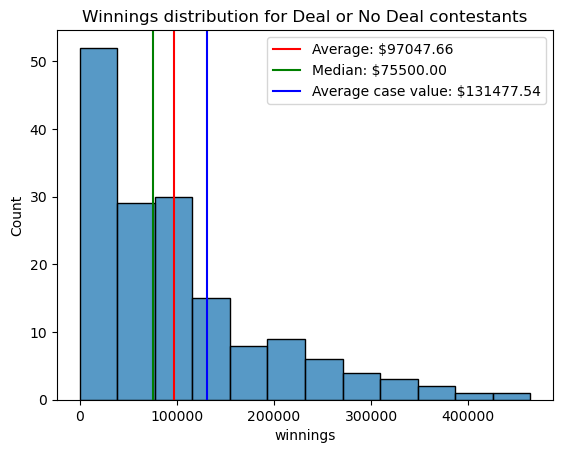

In [4]:
## winnings
sns.histplot(data=round_data, x='winnings')
plt.title('Winnings distribution for Deal or No Deal contestants')
plt.axvline(x=round_data['winnings'].mean(), color='r', label=f'Average: ${round_data["winnings"].mean():.2f}')
plt.axvline(x=round_data['winnings'].median(), color='g', label=f'Median: ${round_data["winnings"].median():.2f}')
plt.axvline(x=case_values['values'].mean(), color='b', label=f'Average case value: ${case_values["values"].mean():.2f}')
plt.legend()
plt.show()

c:\Users\Owner\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


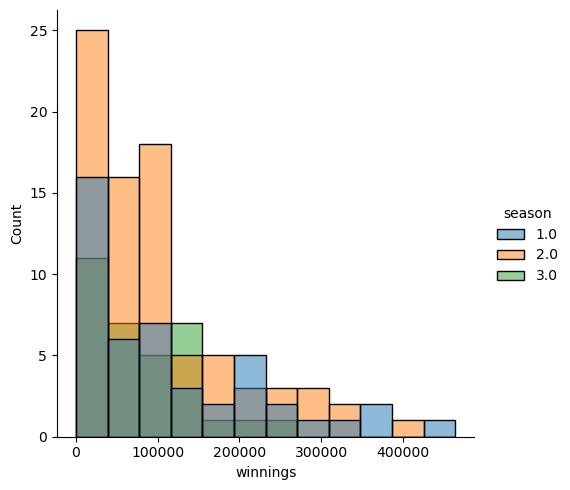

In [5]:
sns.displot(data=round_data, x='winnings', hue='season', palette='tab10')
plt.show()

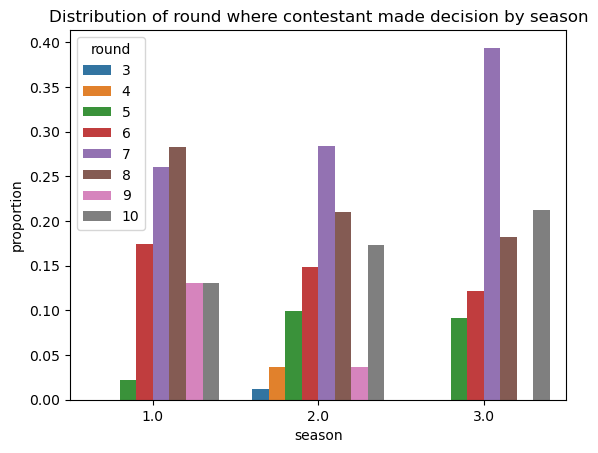

In [6]:
decision_made_count_data = round_data.loc[round_data['winnings'].notnull(), :].groupby(['round', 'season'], as_index=False).size()
decision_made_count_data['proportion'] = decision_made_count_data.groupby('season')['size'].transform(lambda x: x / x.sum())
sns.barplot(
    data=decision_made_count_data,
    x='season',
    y='proportion',
    hue='round'
)
plt.title('Distribution of round where contestant made decision by season')
plt.show()

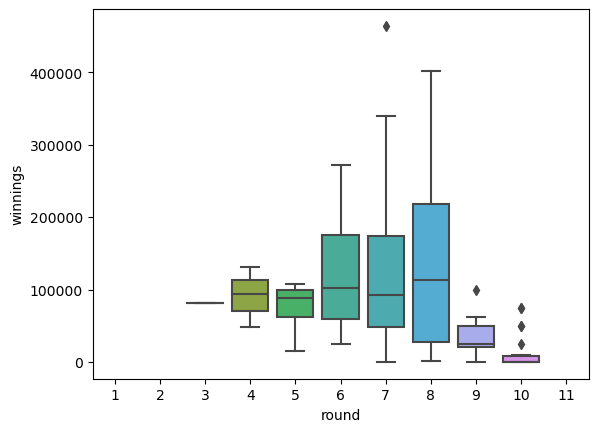

In [7]:
sns.boxplot(data=round_data, x='round', y='winnings')
plt.show()

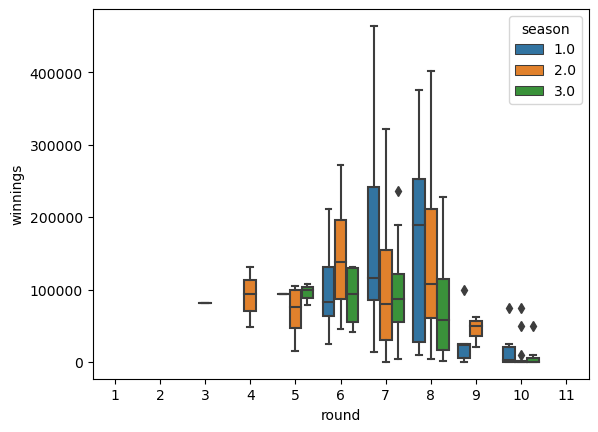

In [8]:
sns.boxplot(data=round_data, x='round', y='winnings', hue='season')
plt.show()

### Relative deal quality

Closely related to winnings is the quality of the deal that the player made. While big numbers are obviously preferred by the contestant, knowing when to take the deal rather than taking on more risk is not easy and can be an indicator of how well the player did during the game. This also normalizes player performance to account for the random nature of the case selection, as some players can eliminate values that have significant impact on their offers, positively or negatively. One thing to note about this analysis is that not every game has a 'what if' sequence at the end; that is, the host may decide to let the player keep selecting cases after a deal has been made depending on the board. However, I think it is reasonable to conclude that this is ommission is okay, since everytime the 'what if' sequence only occurs if the player accepted a deal lower than the highest remaining amount on the board (to see if they made the best deal).

We see that more than half of the players made a 'good deal'; that is, they were able to 'sell' their case to the banker for more than it was worth. This aligns with intuition since the cases are randomized each game. Interestingly, only 10% of players made the 'best deal' by taking the highest possible offer made OR keeping their case until the end which exceeded every offer they received. Contestants were also more likely to 'stay too late' (make a deal later than the maximum offer round/stay until the end of the game) than 'leave too early' (make a deal earlier than the maximum offer round). In about 20% of cases we see that contestants should have stayed until the end of the game since they took a deal worse than the value of their case. Comparing across seasons, we see that while the 'good deal' and 'stayed too late' proportions are roughly constant, there is some interesting variation in the other variables by season. The 'left too early' proportion increases with each season, suggesting that players either were not willing to take on the risk of continuing or received a good enough offer to get them to leave. The 'should have stayed' proportion drops from season 1 to 2 but stabilizes in season 3, while the 'best deal' proportion declines in each successive season. This could be a result of player behavior, but another possible explanation could be that the way the deal is calculated also changes across seasons. 

*The key takeaway from this subsection is that the distribution of offers requires more exploration and may reveal some useful insights for how to model the banker's offer based on its relationship with other variables.*

In [9]:
best_deal_data = round_data.groupby('ID', as_index=False).agg(
    winnings=pd.NamedAgg('winnings', 'max'),
    max_offer=pd.NamedAgg('offer', 'max'),
    original_case_value=pd.NamedAgg('original_case_value','max')
)
best_deal_data['season'] = round_data[['ID', 'season']].drop_duplicates().reset_index(drop=True)['season']
best_deal_data['decision_round'] = round_data.loc[round_data['winnings'].notnull(), 'round'].reset_index(drop=True)
best_deal_data['max_offer_round'] = round_data.loc[round_data.groupby(['ID'])['offer'].rank(method='first', ascending=False) == 1, 'round'].reset_index(drop=True)
best_deal_data['best_deal_column'] = best_deal_data[['winnings', 'max_offer', 'original_case_value']].idxmax(axis=1)
best_deal_data['best_deal'] = best_deal_data['best_deal_column'] == 'winnings'
best_deal_data['good_deal'] = best_deal_data['winnings'] > best_deal_data['original_case_value']
best_deal_data['stayed_too_late'] = best_deal_data['decision_round'] > best_deal_data['max_offer_round']
best_deal_data['left_too_early'] = best_deal_data['decision_round'] < best_deal_data['max_offer_round']
best_deal_data['should_have_stayed'] = (best_deal_data['best_deal_column'] == 'original_case_value') & (best_deal_data['original_case_value'] > best_deal_data['winnings'])

In [10]:
print(f"% of contestants who made the best deal: {100 * best_deal_data['best_deal'].sum() / best_deal_data.shape[0]:.2f}")
print(f"% of contestants who made a good deal: {100 * best_deal_data['good_deal'].sum() / best_deal_data.shape[0]:.2f}")
print(f"% of contestants who stayed too late: {100 * best_deal_data['stayed_too_late'].sum() / best_deal_data.shape[0]:.2f}")
print(f"% of contestants who left too early: {100 * best_deal_data['left_too_early'].sum() / best_deal_data.shape[0]:.2f}")
print(f"% of contestants who should have stayed until the end: {100 * best_deal_data['should_have_stayed'].sum() / best_deal_data.shape[0]:.2f}")

% of contestants who made the best deal: 10.00
% of contestants who made a good deal: 58.12
% of contestants who stayed too late: 50.62
% of contestants who left too early: 38.12
% of contestants who should have stayed until the end: 20.62


In [11]:
best_deal_data.groupby('season', as_index=False).agg(
    best_deal_prop=pd.NamedAgg('best_deal', 'mean'),
    good_deal_prop=pd.NamedAgg('good_deal', 'mean'),
    too_late_prop=pd.NamedAgg('stayed_too_late', 'mean'),
    too_early_prop=pd.NamedAgg('left_too_early', 'mean'),
    should_have_stayed_prop=pd.NamedAgg('should_have_stayed', 'mean'),
)

,season,best_deal_prop,good_deal_prop,too_late_prop,too_early_prop,should_have_stayed_prop
0,1.0,0.152174,0.586957,0.521739,0.282609,0.260870
1,2.0,0.098765,0.580247,0.493827,0.407407,0.185185
2,3.0,0.030303,0.575758,0.515152,0.454545,0.181818


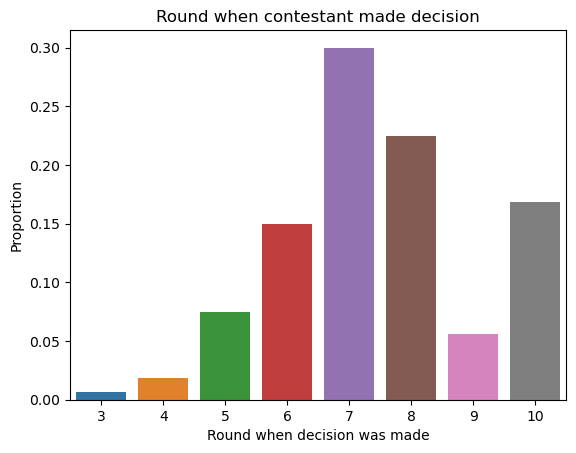

In [12]:
sns.barplot(
    data=best_deal_data['decision_round'].value_counts(normalize=True).reset_index(),
    x='decision_round',
    y='proportion',
)
plt.title('Round when contestant made decision')
plt.ylabel('Proportion')
plt.xlabel('Round when decision was made')
plt.show()

## offers

### distribution of offers

The distribution of the offers random variable is right-skewed, similar to contestant winnings. Examining the distribution by round, we see an increase in the median offer and variance of the banker's offers to the contestant. This aligns with the idea that the banker updates the offer based on the current state of the board and the general increase in successive rounds indicates the offer is related to the probability that the contestant selected the highest remaining value on the board as their original case. The final check for controlling the distribution across season suggests their is no major difference in the offers as the show stayed longer on television. Interestingly, when controlling for season and round, however, there is a noteworthy difference in the offer distribution for early rounds, specifically round 1, for season 3 compared to the first two seasons. This may follow from the fact that the increased in popularity and was able to make higher offers early in the game, although the visible difference in distribution across seasons seems to fall off by the third to fourth round. These results suggest that when building the model, it will be important to account for variation in the data by season, at least for the first few rounds.

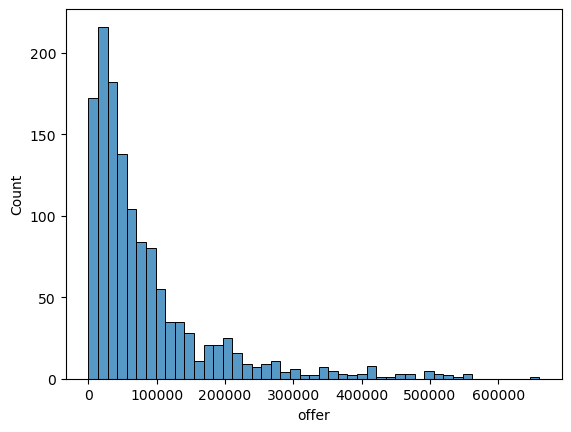

In [13]:
sns.histplot(data=round_data, x='offer')
plt.show()

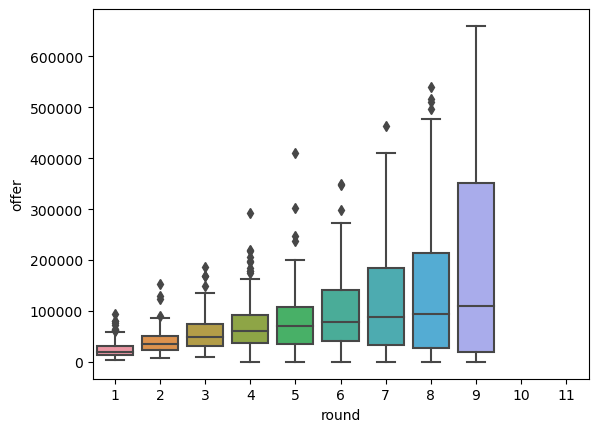

In [14]:
sns.boxplot(data=round_data, x='round', y='offer')
plt.show()

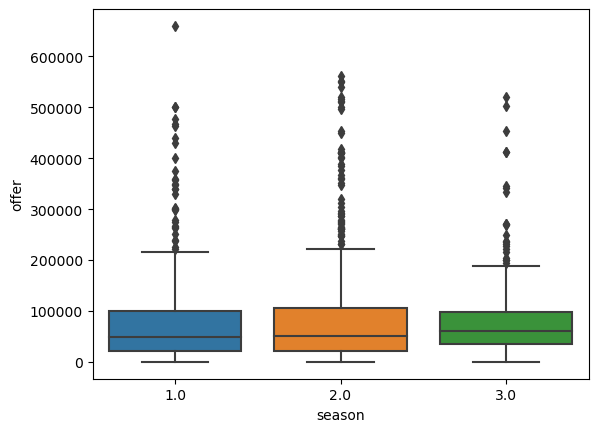

In [15]:
sns.boxplot(data=round_data, x='season', y='offer')
plt.show()

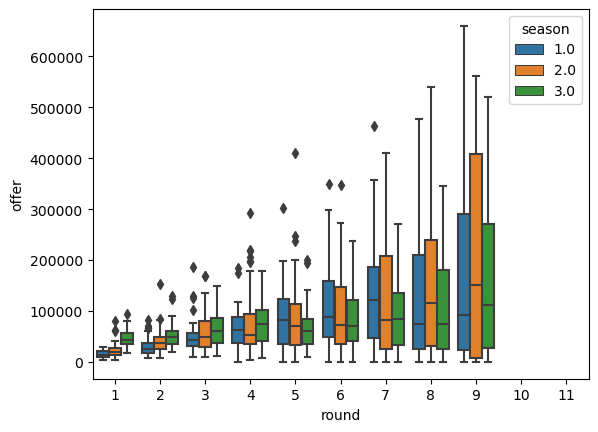

In [16]:
sns.boxplot(data=round_data, x='round', y='offer', hue='season')
plt.show()

### Offers accounting for the board

From our exploration of the offers distribution, we saw it was related to the round and surmised that this likely had to do with the state of the board and the remaining values available. To verify this, we average the remaining values on the board as a way to summarize its state and compare it to the round offer. The boxplots across the round illustrate our hypothesis has merit, as the offers in the later rounds get closer and closer to the average remaining on the board. As the banker gets more information from the board with each player selection, the bank needs to adjust the offer to convince the contestant to take a deal potentially lower than their original case selection. Controlling for season, we again see how the increased offer size at the start of the game varies significantly by season, but this difference in the distribution dissipates in later rounds.

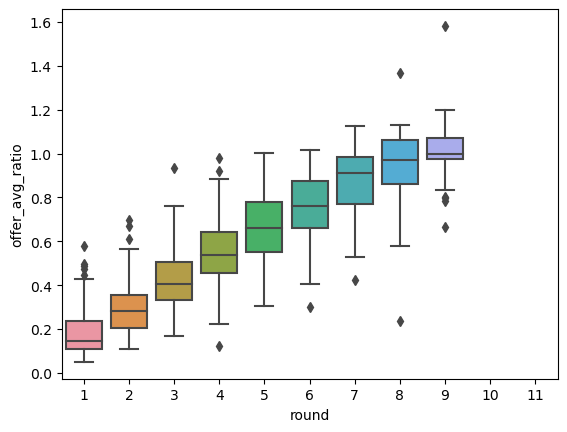

In [17]:
sns.boxplot(data=round_data, x='round', y='offer_avg_ratio')
plt.show()

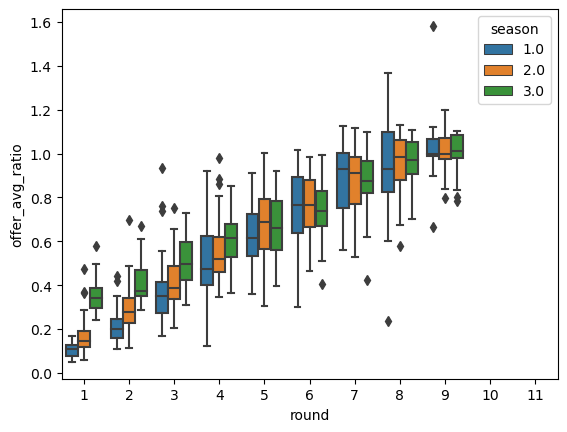

In [18]:
sns.boxplot(data=round_data, x='round', y='offer_avg_ratio', hue='season')
plt.show()

### Offers and Remaining Average

Now that we have seen a relationship between the round, the board state, and the offer, it is a good time to check the relationship between the covariates and the offer based on information we would have if we were the banker at the end of the round. Plotting the offer against the average remaining values on the board, we see a weak linearly relationship between the variables. This is likely due to the fact that offer also depends upon the round in which it was made. Controlling for this and fitting a line using linear regression from seaborn's lmplot function, we find that there is a strong linear relationship between offer and remaining average values when controlling for the round. The final check is to examine whether controlling for season also results in noteworthy differences in the intercept and slope by round. As we can see from the visualizations, round 1 may have some differences in slope and intercept comparing season 3 to the first two seasons, but the difference is roughly negligible across the remaining rounds. These results also illustrate to us that it would be worthwhile to try out linear regression as a model in addition to other machine learning algorithms when building our model.

In [19]:
## comparing average remaining to offer
offer_round_data = round_data.query('offer.notnull()')

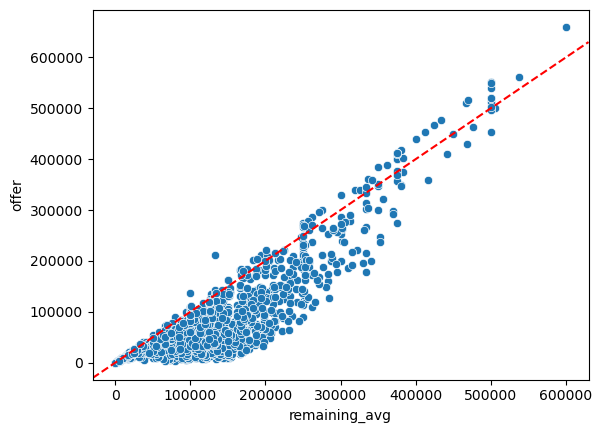

In [20]:
## average/offer scatterplot colored by round
lm = sns.scatterplot(data=offer_round_data, x='remaining_avg', y='offer')
ax = lm.axes
# Use axline to add a line with slope=1, starting from the origin (0, 0)
ax.axline((0, 0), slope=1, color='red', linestyle='--')
plt.show()

c:\Users\Owner\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


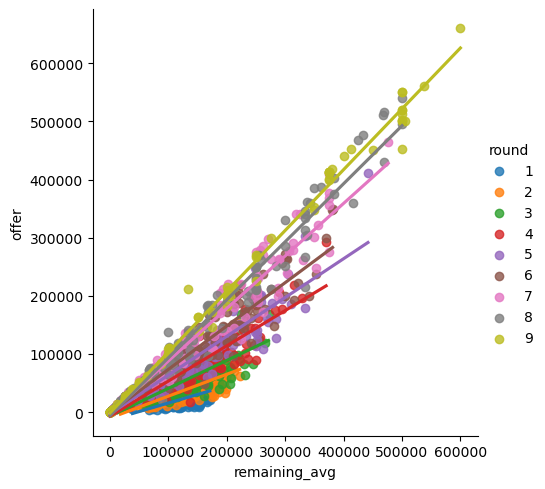

In [21]:
sns.lmplot(data=offer_round_data, x='remaining_avg', y='offer', hue='round', ci=None, palette='tab10')
plt.show()

c:\Users\Owner\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


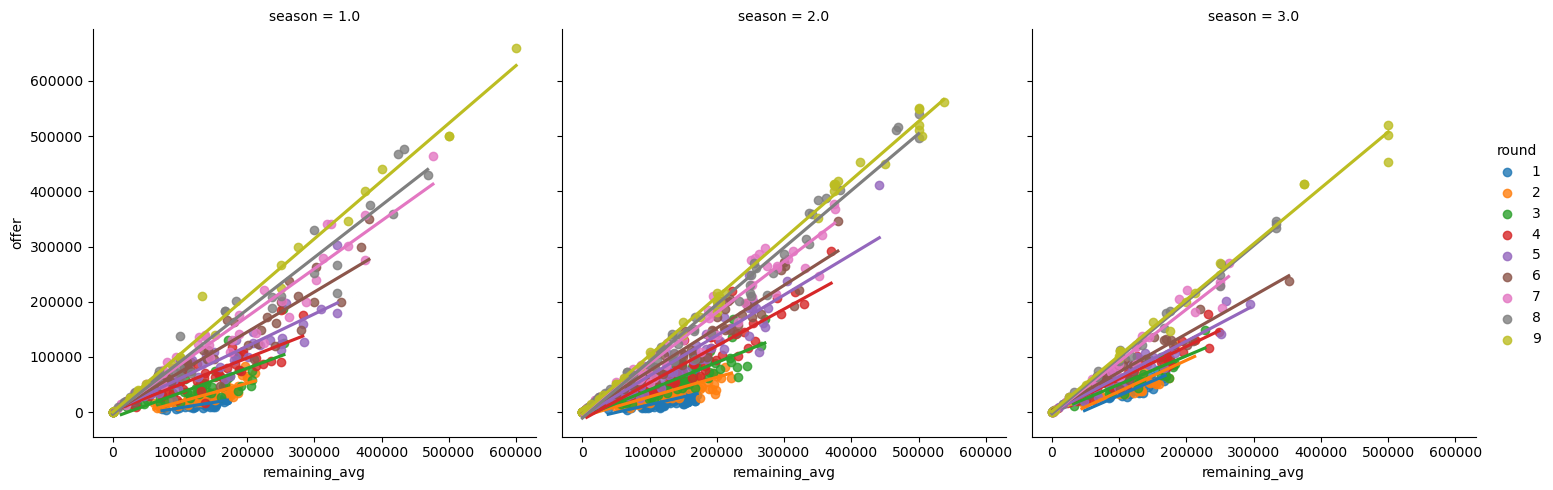

In [22]:
sns.lmplot(data=offer_round_data, x='remaining_avg', y='offer', hue='round', ci=None, col='season', palette='tab10')
plt.show()

c:\Users\Owner\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


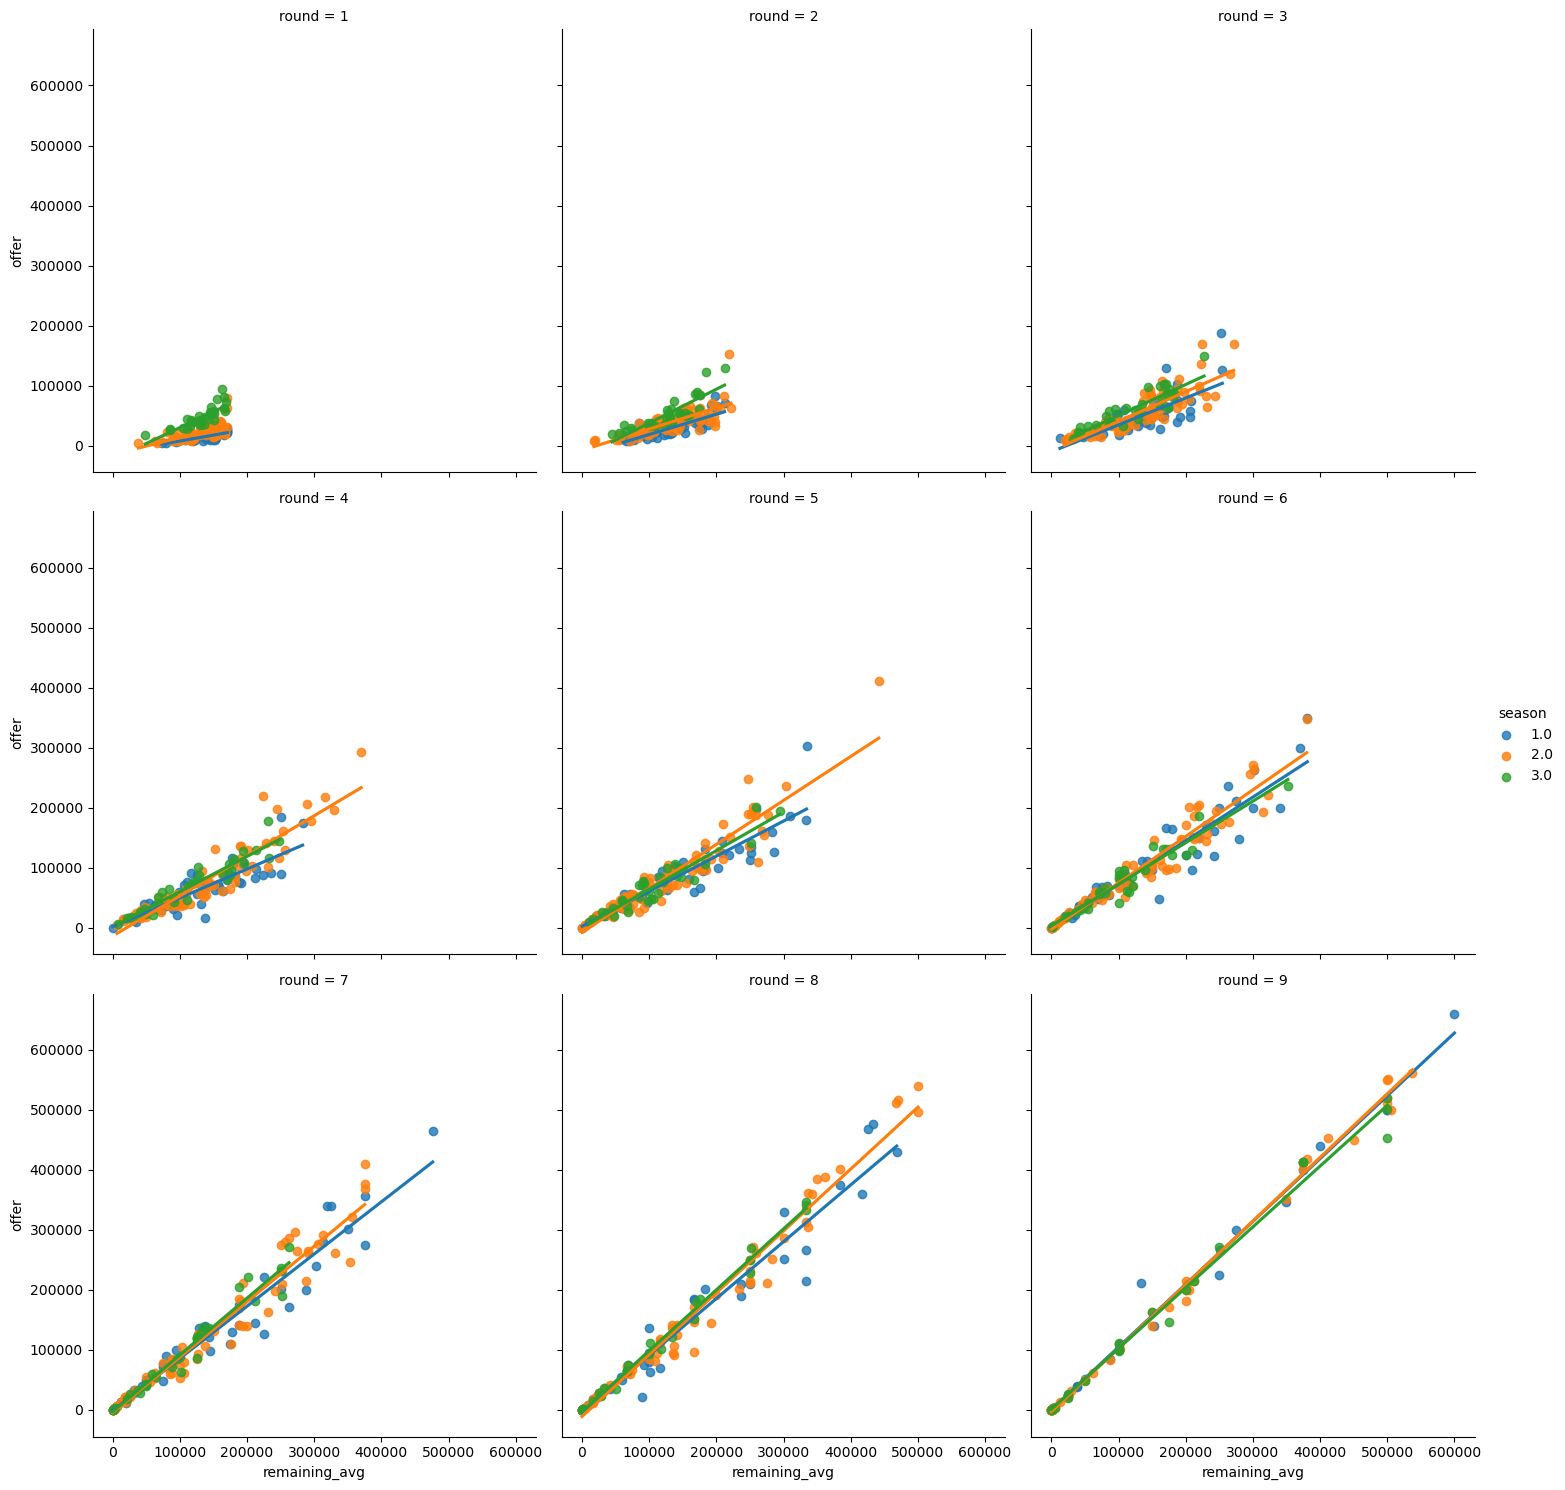

In [23]:
sns.lmplot(data=offer_round_data, x='remaining_avg', y='offer', hue='season', col='round', col_wrap=3, ci=None, palette='tab10')
plt.show()